# Natural Language Processing (NLP)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/Users/jovanvelichkoski/PycharmProjects/IntroToDataScience/AuditoryExercises/Datasets/emotions-dataset.csv")
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
2,i wasnt going to post today as i am feeling qu...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


<Axes: xlabel='emotion'>

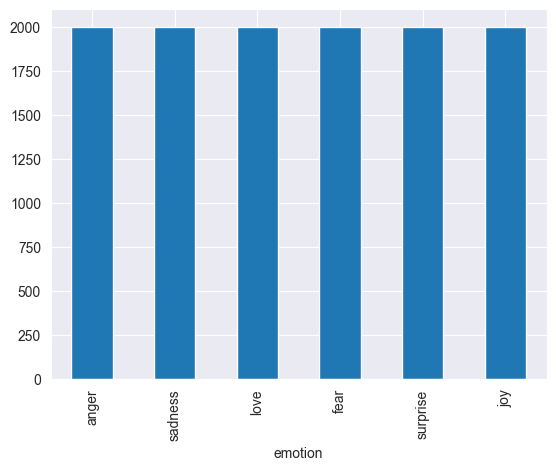

In [4]:
df["emotion"].value_counts().plot.bar()

In [5]:
df.isnull().sum()

message    0
emotion    0
dtype: int64

<Axes: ylabel='Frequency'>

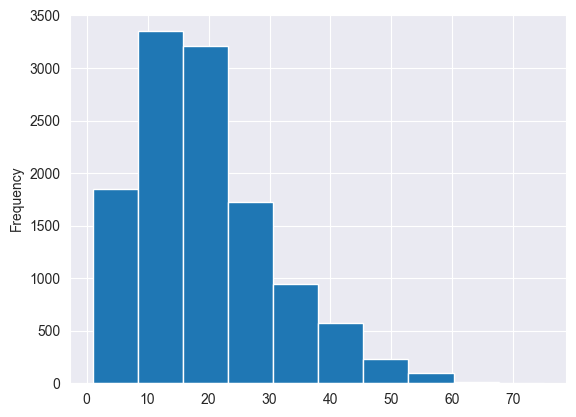

In [6]:
df["message"].str.split(" ").apply(len).plot.hist()

<Axes: >

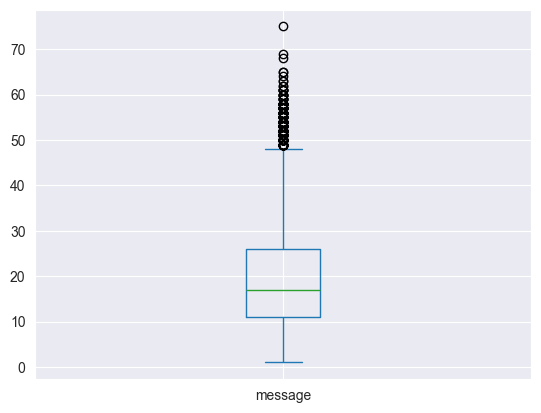

In [7]:
df["message"].str.split().apply(len).plot.box()

In [8]:
df = df[df["message"].str.split().apply(len) < 45].copy(deep=True)
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
5,i feel stubborn because i just want my seattle...,anger
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


<Axes: ylabel='Frequency'>

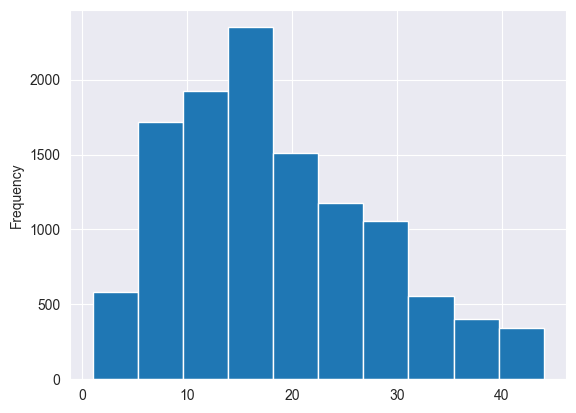

In [9]:
df["message"].str.split().apply(len).plot.hist()

<Axes: >

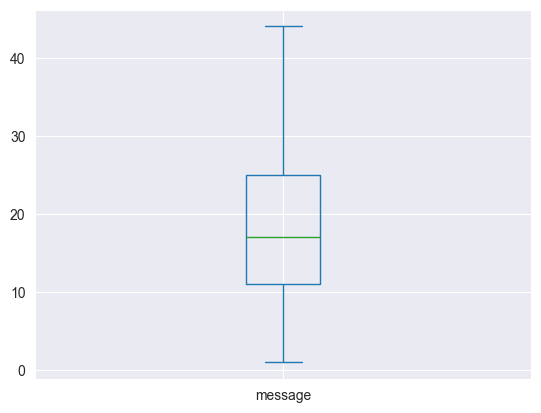

In [10]:
df["message"].str.split().apply(len).plot.box()

In [13]:
X, y, num_classes = df["message"], df["emotion"].astype("category").cat.codes, len(df["emotion"].unique())

In [14]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

In [15]:
def build_vocab(texts, max_vocab_size):
    counter = Counter()

    for sentence in texts:
        counter.update(sentence.split())

    # Special tokens
    vocab = {
        "<PAD>": 0,
        "<OOV>": 1
    }

    for idx, (word, _) in enumerate(
        counter.most_common(max_vocab_size - 2), start=2
    ):
        vocab[word] = idx

    return vocab

In [16]:
max_vocab_size = 10000
vocab = build_vocab(train_X.values, max_vocab_size)

In [17]:
def texts_to_sequences(texts, vocab):
    sequences = []

    for sentence in texts:
        seq = [
            vocab.get(word, vocab["<OOV>"])
            for word in sentence.split()
        ]
        sequences.append(seq)

    return sequences

In [18]:
train_X = texts_to_sequences(train_X.values, vocab)
val_X   = texts_to_sequences(val_X.values, vocab)
test_X  = texts_to_sequences(test_X.values, vocab)

In [19]:
def pad(sequences, pad_value=0):
    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )

In [20]:
train_X = pad(train_X, pad_value=0)
val_X   = pad(val_X,pad_value=0)
test_X  = pad(test_X, pad_value=0)

In [21]:
train_y = torch.tensor(train_y.values, dtype=torch.long)
val_y   = torch.tensor(val_y.values, dtype=torch.long)
test_y  = torch.tensor(test_y.values, dtype=torch.long)

In [23]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, 128, padding_idx=0
        )

        self.conv1 = nn.Conv1d(128, 32, kernel_size=4, padding=2)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, padding=2)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm1 = nn.LSTM(64, 128, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.1)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)          # (batch, seq, 128)
        x = x.permute(0, 2, 1)         # (batch, 128, seq)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.permute(0, 2, 1)         # (batch, seq, features)

        x, _ = self.lstm1(x)
        _, (h, _) = self.lstm2(x)

        return self.fc(h[-1])

In [28]:
model = CNN_LSTM(
    vocab_size=len(vocab),
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [29]:
train_losses = []
val_losses = []

epochs = 12
batch_size = 64

for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0

    for i in range(0, len(train_X), batch_size):
        X_batch = train_X[i:i+batch_size]
        y_batch = train_y[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / (len(train_X) // batch_size)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        X_val = val_X
        y_val = val_y

        outputs = model(X_val)
        val_loss = criterion(outputs, y_val)
        running_val_loss += val_loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct = (preds == y_val).sum().item()

    avg_val_loss = running_val_loss
    val_losses.append(avg_val_loss)

    val_acc = correct / len(y_val)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Val loss: {avg_val_loss:.4f} | "
        f"Val acc: {val_acc:.4f}"
    )

Epoch 1/12 | Train loss: 1.8060 | Val loss: 1.7804 | Val acc: 0.1874
Epoch 2/12 | Train loss: 1.6739 | Val loss: 1.6820 | Val acc: 0.2526
Epoch 3/12 | Train loss: 1.3558 | Val loss: 1.5081 | Val acc: 0.3312
Epoch 4/12 | Train loss: 1.1110 | Val loss: 1.7015 | Val acc: 0.3328
Epoch 5/12 | Train loss: 0.9544 | Val loss: 1.4100 | Val acc: 0.4389
Epoch 6/12 | Train loss: 0.8690 | Val loss: 1.2056 | Val acc: 0.5148
Epoch 7/12 | Train loss: 0.7277 | Val loss: 1.2295 | Val acc: 0.5407
Epoch 8/12 | Train loss: 0.6380 | Val loss: 1.1267 | Val acc: 0.6155
Epoch 9/12 | Train loss: 0.4513 | Val loss: 1.1755 | Val acc: 0.6543
Epoch 10/12 | Train loss: 0.3133 | Val loss: 0.9958 | Val acc: 0.7124
Epoch 11/12 | Train loss: 0.2403 | Val loss: 1.0827 | Val acc: 0.6984
Epoch 12/12 | Train loss: 0.2009 | Val loss: 1.0573 | Val acc: 0.7286


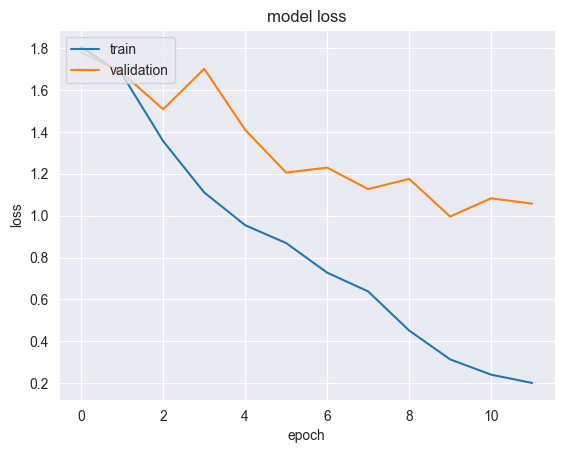

In [30]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
model.eval()

with torch.no_grad():
    X_test = test_X
    y_test = test_y

    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1)
    test_acc = (preds == y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7317


In [35]:
print(classification_report(y_test.cpu().numpy(), preds.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       393
           1       0.86      0.76      0.80       384
           2       0.56      0.68      0.62       393
           3       0.85      0.85      0.85       396
           4       0.55      0.61      0.58       343
           5       0.86      0.93      0.89       413

    accuracy                           0.73      2322
   macro avg       0.74      0.73      0.73      2322
weighted avg       0.74      0.73      0.73      2322



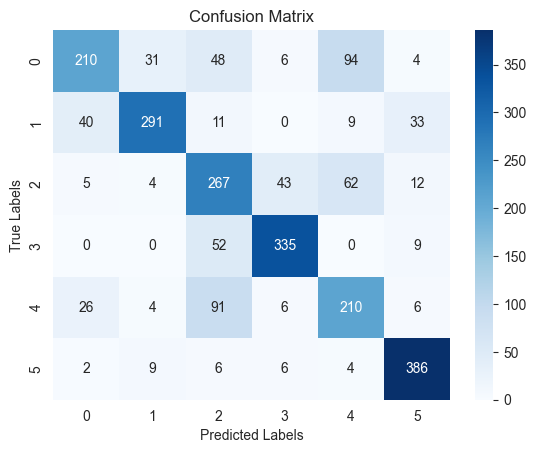

In [36]:
cm = confusion_matrix(
    y_test.numpy(),
    preds.numpy()
)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()